#Problema 13 de la guía 9
##S. Schiavinato LU:153/1
###Tests de bondad de ajuste, no paramétricos, entre datos y una distribución normal dada

In [3]:
%matplotlib inline
import numpy as np
import numpy.linalg as lin
import numpy.random as rnd
import scipy.misc as misc
import scipy.optimize as opt
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5 * (1 + np.sqrt(5)) / 2, 5)
plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["axes.labelsize"] = 20

En la función a continuación se implementa la lógica del test, donde vamos a efectuar un test χ-cuadrado, de Kolmogorov y de Cramer/Von Mises para rechazar (o no) que los datos provengan de la distribución normal dada N(0,2.5). Se grafica el histograma, normalizado de los datos, con bines  entre -7 y 7, con 0.25 de ancho (esto debe verificar que la frecuencia de cada bin sea mayor a 5, como exige el test). A este grafico se le superpone la distribución de la normal. Finalmente para el test de Kolmogorov y Cramer-Von Mises se grafica la acumulativa empírica de los datos (S(x)) y la acumulativa de la normal, para observar gráficamente el test

A continuación se define el test $\chi^2$, comparando la distribución de una gaussiana $N(0,2.5)$ y los datos. Para eso se crea una función, con la cantidad de datos a tomar de la población

In [9]:
def G9E13_Chi2(N = 3000):
    gauss = stats.norm(0, 2.5)
    data = np.loadtxt("datos-G9E13.dat") 
    bins = np.arange(-7,7,0.25)
    #data.sort()
    data = data[:N]
    
    #plt.axhline(y = 10, c="k",ls="--")
    hist, bins = np.histogram(data, bins = bins);
    yerr = np.sqrt(hist)/(hist.sum()*np.diff(bins))
    histNorm = hist/(hist.sum()*np.diff(bins))
    plt.bar(bins[:-1], histNorm, ecolor = "g", yerr = yerr, width = np.diff(bins))
    plt.plot(bins[:-1], gauss.pdf(bins[:-1]), 'r-')
    chi2 = 0
    for i in range(bins[:-1].shape[0]):
        ni = hist[i]
        fi = N * (stats.norm(0,2.5).cdf(bins[i + 1]) - stats.norm(0,2.5).cdf(bins[i]))
        chi2 += (ni - fi)**2/ni
    
    #Imprime los datos
    p = 1 - stats.chi2(bins[:-1].shape[0]).cdf(chi2)
    print("χ2 = {}, p = {}".format(chi2, p))

Ahora, se pide observar el resultado del test, para $N = 3000$

χ2 = 66.26647034176688, p = 0.142050775060386


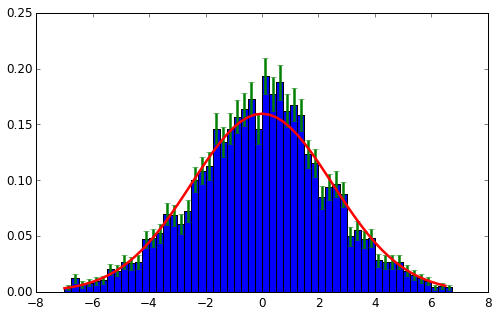

In [10]:
G9E13_Chi2(N=3000)

El p-valor obtenido es mayor a la siginificacia exigida ($\alpha = 0.05$), por lo que el test no rechaza la hipotesis nula. 

Se construye, en simultaneo otros dos test, de Kolmogorov-Smirnov y de Cramer-Von Mises, que no exigen el binado de los datos. Estos consisten en encontrar un estadístico que compare la función acumulativa de los datos, que se denomina función acumulativa empirica, y la función acumulativa de la distribución de referencia.

La función acumulativa empirica se define:  
$ \tilde{F}_x = \begin{cases} 0 & x < x_i\\ \frac{1}{n}  & x_i < x < x_{i+1} \\ 1 & x > x_n \end{cases} $

In [24]:
def Fn(data):
    N = data.shape[0]
    data = np.sort(data) #Ordeno primero
    S = [[data[0], 1/N]] #Primer punto para la S(Xi)
    for i in range(1, N):
        #print(i)
        if data[i] == data[i-1]:
            S[-1][1] += 1/N  #Si se repite, sumo 1/N más
        else: 
            S.append([data[i], 1.0/N + S[-1][1]]) #Por cada dato, subo un 1/N
    S = np.array(S)
    return S

Se grafica esta definición, con algunos datos, para mostrar el resultado.

[[-2.35    0.05  ]
 [-2.3374  0.1   ]
 [-1.169   0.15  ]
 [-0.9015  0.2   ]
 [-0.618   0.25  ]
 [-0.3862  0.3   ]
 [-0.2022  0.35  ]
 [-0.065   0.4   ]
 [ 0.3523  0.45  ]
 [ 0.3895  0.5   ]
 [ 0.4647  0.55  ]
 [ 0.5244  0.6   ]
 [ 0.5585  0.65  ]
 [ 0.6694  0.7   ]
 [ 1.0323  0.75  ]
 [ 1.3544  0.8   ]
 [ 1.4237  0.85  ]
 [ 1.4753  0.9   ]
 [ 1.5359  0.95  ]
 [ 4.1627  1.    ]]


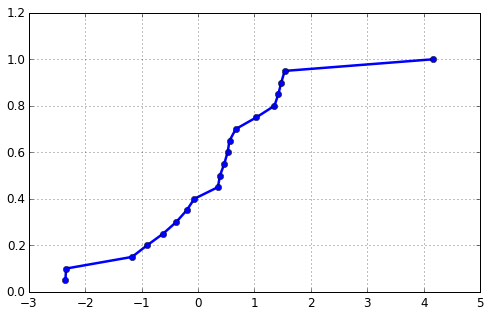

In [25]:
data = np.loadtxt("datos-G9E13.dat") 
S = Fn(data[:20])
print(S)
plt.grid()
plt.plot(S[:,0], S[:,1], 'bo-');

Para comprar en cada observación, se graficara la ECDF y la CDF en una misma función, para una cantidad de datos $N$

In [41]:
def plotECDF(N = 3000): #Grafico la CDF empirica y la de la gaussiana
    #Obtengo los datos
    data = np.loadtxt("datos-G9E13.dat") 
    data = data[:N] #Trunco hasta N elementos
    data = np.sort(data) #Ordeno primero
    S = Fn(data) #Obtengo la ecdf
    f = stats.norm(0,2.5)
    plt.figure()
    plt.plot(S[:,0], S[:,1], 'b-', label = "Acumulada de datos")
    plt.plot(S[:,0], f.cdf(S[:,0]), 'r-', label = "Acumulada de gaussiana N(0, 2.5)");
    plt.legend(loc = 0)

El test Kolmogorov-Smirnov consiste en encontrar el módulo de máxima diferencia entre la función acumulativa empirica y la acumulativa de referencia, es decir 

$K_n = \sup_{x_i} \{| \tilde{F}_x(x_i) - F(x_i) |\}$  

que de la tabla (http://www.jstor.org/stable/2283970) tenemos que asintóticamente, es decir con cantidad de muestras $N>>1$, el valor crítico para $\alpha = 0.05$ es igual a 

$K_{\text{crit}}(N) = \dfrac{0,886}{\sqrt{N}}$

Con esto se define el test:

In [37]:
def G9E13_KS(N = 3000):
    '''Efectua sobre N datos del archivo datos-G9E13.dat un test
    de Kolmogorov-Smirnov y Cramer-Von Mises, graficando la función 
    acumulativa de la normal N(0,2.5) y la acumulativa empirica de
    los datos'''
    gauss = stats.norm(0, 2.5)
    data = np.loadtxt("datos-G9E13.dat") 
    data = data[:N]
    data = np.sort(data) #Ordeno primero
    S = Fn(data) #Obtengo la ecdf
    
    ##Test de Kolmogorov-Smirnov
    #Ahora calculamos el estadístico
    K = np.abs(S[:,1] - gauss.cdf(S[:,0])).max()
    print("Kn = {}, Kcrit = {}".format(K, 0.886/np.sqrt(N)))

El test de Cramer-Von Mises consiste en calcular el siguiente estadístico 

$\displaystyle W_n = \int (\tilde{F}_x(x) - F(x))^2 f(x) dx$

que de la tabla (http://www.maths.bath.ac.uk/~jjf23/papers/cramer.pdf) se ve para una significancia $\alpha = 0.05$ el valor crítico, asisntóticamente, es

$W_{\text{crit}} = 0,03536$

Si tenemos un valor del estadístico mayor, se rechaza la hipotesis

In [38]:
def G9E13_CMS(N = 3000):
    gauss = stats.norm(0, 2.5)
    data = np.loadtxt("datos-G9E13.dat") 
    data = data[:N]
    data = np.sort(data) #Ordeno primero
    S = Fn(data) #Obtengo la ecdf
    
    ##Test de Cramer-Von Mises
    #integro numéricamente con x ϵ {Xi}
    Cn = np.trapz((S[:,1] - gauss.cdf(S[:,0]))**2 * gauss.pdf(S[:,0]))
    print("Cn = {}, Ccrit = {}".format(Cn, 0.0356))

Se encuentra que el test de χ-cuadrado no es capaz de de rechazar la hipótesis nula, pero el test de Kolmogorov y de Cramer/Von Mises si, exiguiendo una significacia ɑ=0.05. Ahora para 4000, 5000 y 6000 muestras

Kn = 0.0319420723950975, Kcrit = 0.016176072864985905
Cn = 0.06637887158310515, Ccrit = 0.0356


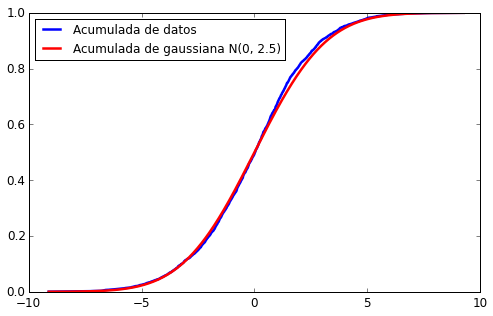

In [43]:
plotECDF(N = 3000)
G9E13_KS(N = 3000)
G9E13_CMS(N = 3000)

Se puede observar que estos test rechazan la hipotesis nula con $\alpha = 0.05$, por lo que no es necesario seguir testeando.  

Como del gráfico no podemos sacar mucha información, se precinde de ellos a continuación, donde vemos el test de $\chi^2$, KS y CMS para más elementos de la muestra

χ2 = 81.84099320372823, p = 0.01091550278063036
Kn = 0.03169670961601789, Kcrit = 0.014008890034545921
Cn = 0.10499035036681124, Ccrit = 0.0356
N = 5000
χ2 = 94.31674453820938, p = 0.000768651074386173
Kn = 0.028961779378805175, Kcrit = 0.012529932162625622
Cn = 0.13203772936350716, Ccrit = 0.0356


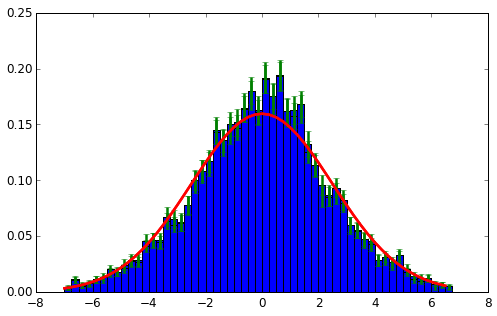

In [46]:
G9E13_Chi2(N = 4000)
G9E13_KS(N = 4000)
G9E13_CMS(N = 4000)

χ2 = 94.31674453820938, p = 0.000768651074386173
Kn = 0.028961779378805175, Kcrit = 0.012529932162625622
Cn = 0.13203772936350716, Ccrit = 0.0356


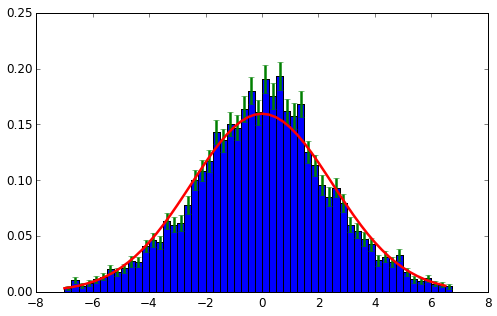

In [48]:
G9E13_Chi2(N = 5000)
G9E13_KS(N = 5000)
G9E13_CMS(N = 5000)

χ2 = 114.22165258965553, p = 4.9063444049757265e-06
Kn = 0.028261779378805918, Kcrit = 0.011438210815799238
Cn = 0.1692396654918193, Ccrit = 0.0356


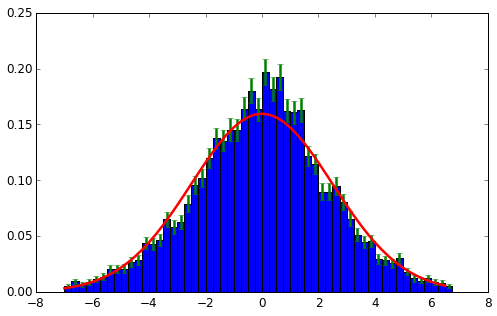

In [47]:
G9E13_Chi2(N = 6000)
G9E13_KS(N = 6000)
G9E13_CMS(N = 6000)

Ya con 4000 datos el test de $\chi^2$ es capaz de rechazar la hipótesis nula. Para completar, se grafica la totalidad de los datos, sobrepuesto a la distribución normal propuesta, más una gaussiana con menor varianza y otra con mayor varianza, para observar visualmente la normalidad de los datos

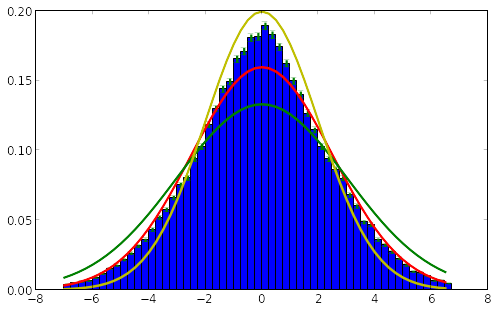

In [7]:
gauss = stats.norm(0, 2.5)
data = np.loadtxt("datos-G9E13.dat") 
bins = np.arange(-7,7,0.25)
#plt.axhline(y = 10, c="k",ls="--")
hist, bins = np.histogram(data, bins = bins);
yerr = np.sqrt(hist)/(hist.sum()*np.diff(bins))
histNorm = hist/(hist.sum()*np.diff(bins))
plt.bar(bins[:-1], histNorm, ecolor = "g", yerr = yerr, width = np.diff(bins));
plt.plot(bins[:-1], stats.norm(0,2.5).pdf(bins[:-1]), 'r-')
plt.plot(bins[:-1], stats.norm(0,3).pdf(bins[:-1]), 'g-')
plt.plot(bins[:-1], stats.norm(0,2).pdf(bins[:-1]), 'y-');

Este gráfico permite visualmente encontrar, sin mucho rigor, que los datos no provienen de una distribución normal, ya que al ajustar de forma acertada el centro de probabilidad de los datos no ajusta a las colas, y lo contrario. Se podría efectuar un test específico para probar la normalidad, como un test Runs o de Wilcoxon